In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
# setup
sns.set(style="darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [4]:
train = pd.read_csv('data/train.csv', parse_dates=['date'])
test = pd.read_csv('data/test.csv', parse_dates=['date'])
stores = pd.read_csv('data/stores.csv')
stores = stores.rename(columns={'type': 'store_type', 'cluster': 'store_cluster'})

oil = pd.read_csv('data/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('data/holidays_events.csv', parse_dates=['date'])

In [8]:
# peek at data
print(stores.info())
print(stores.head())
# print(train.tail(10))
# print(holidays.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   store_nbr      54 non-null     int64 
 1   city           54 non-null     object
 2   state          54 non-null     object
 3   store_type     54 non-null     object
 4   store_cluster  54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None
   store_nbr           city                           state store_type  \
0          1          Quito                       Pichincha          D   
1          2          Quito                       Pichincha          D   
2          3          Quito                       Pichincha          D   
3          4          Quito                       Pichincha          D   
4          5  Santo Domingo  Santo Domingo de los Tsachilas          D   

   store_cluster  
0             13  
1             13  
2              8  
3              9  
4 

In [5]:
# nulls
print("Missing values:\n", train.isnull().sum())

Missing values:
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


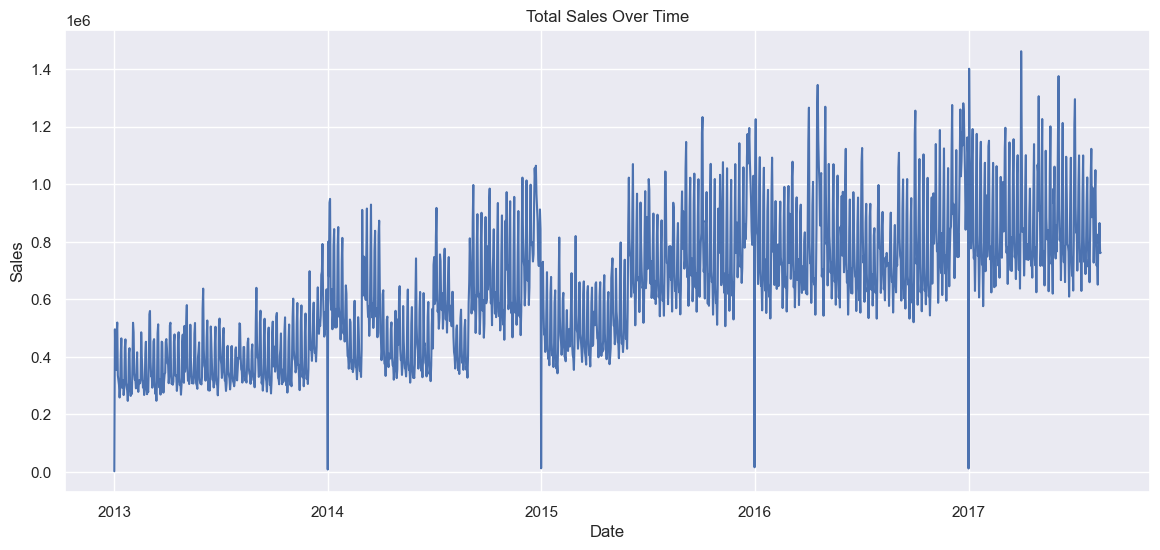

In [6]:
# time series of daily sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()

plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title("Total Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

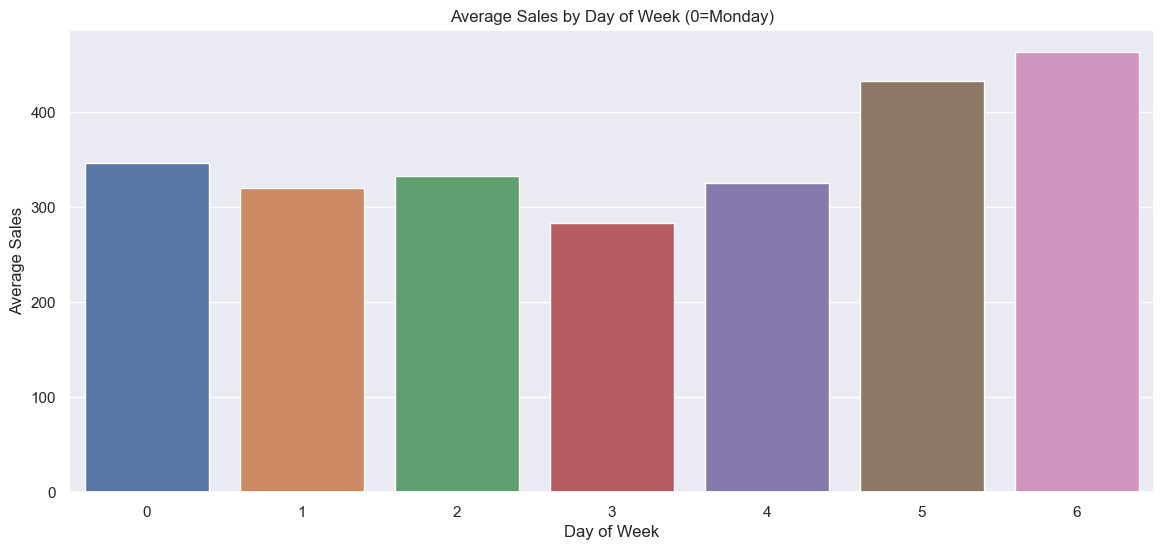

In [7]:
# day of the week
train['day_of_week'] = train['date'].dt.dayofweek
weekly_sales = train.groupby('day_of_week')['sales'].mean()

sns.barplot(x=weekly_sales.index, y=weekly_sales.values)
plt.title("Average Sales by Day of Week (0=Monday)")
plt.xlabel("Day of Week")
plt.ylabel("Average Sales")
plt.show()

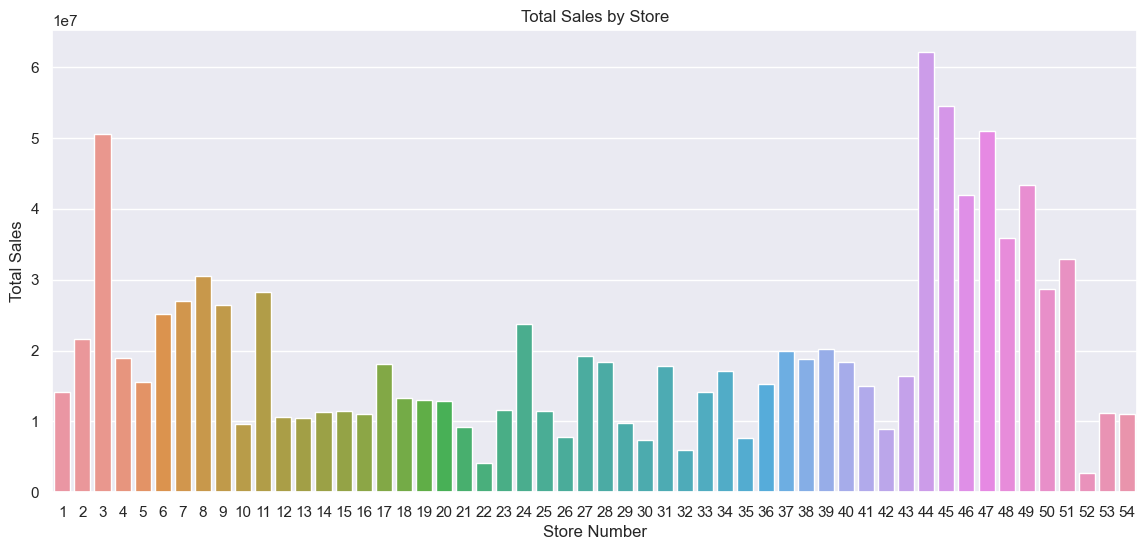

In [8]:
# sales by store
store_sales = train.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)

sns.barplot(x=store_sales.index, y=store_sales.values)
plt.title("Total Sales by Store")
plt.xlabel("Store Number")
plt.ylabel("Total Sales")
plt.show()

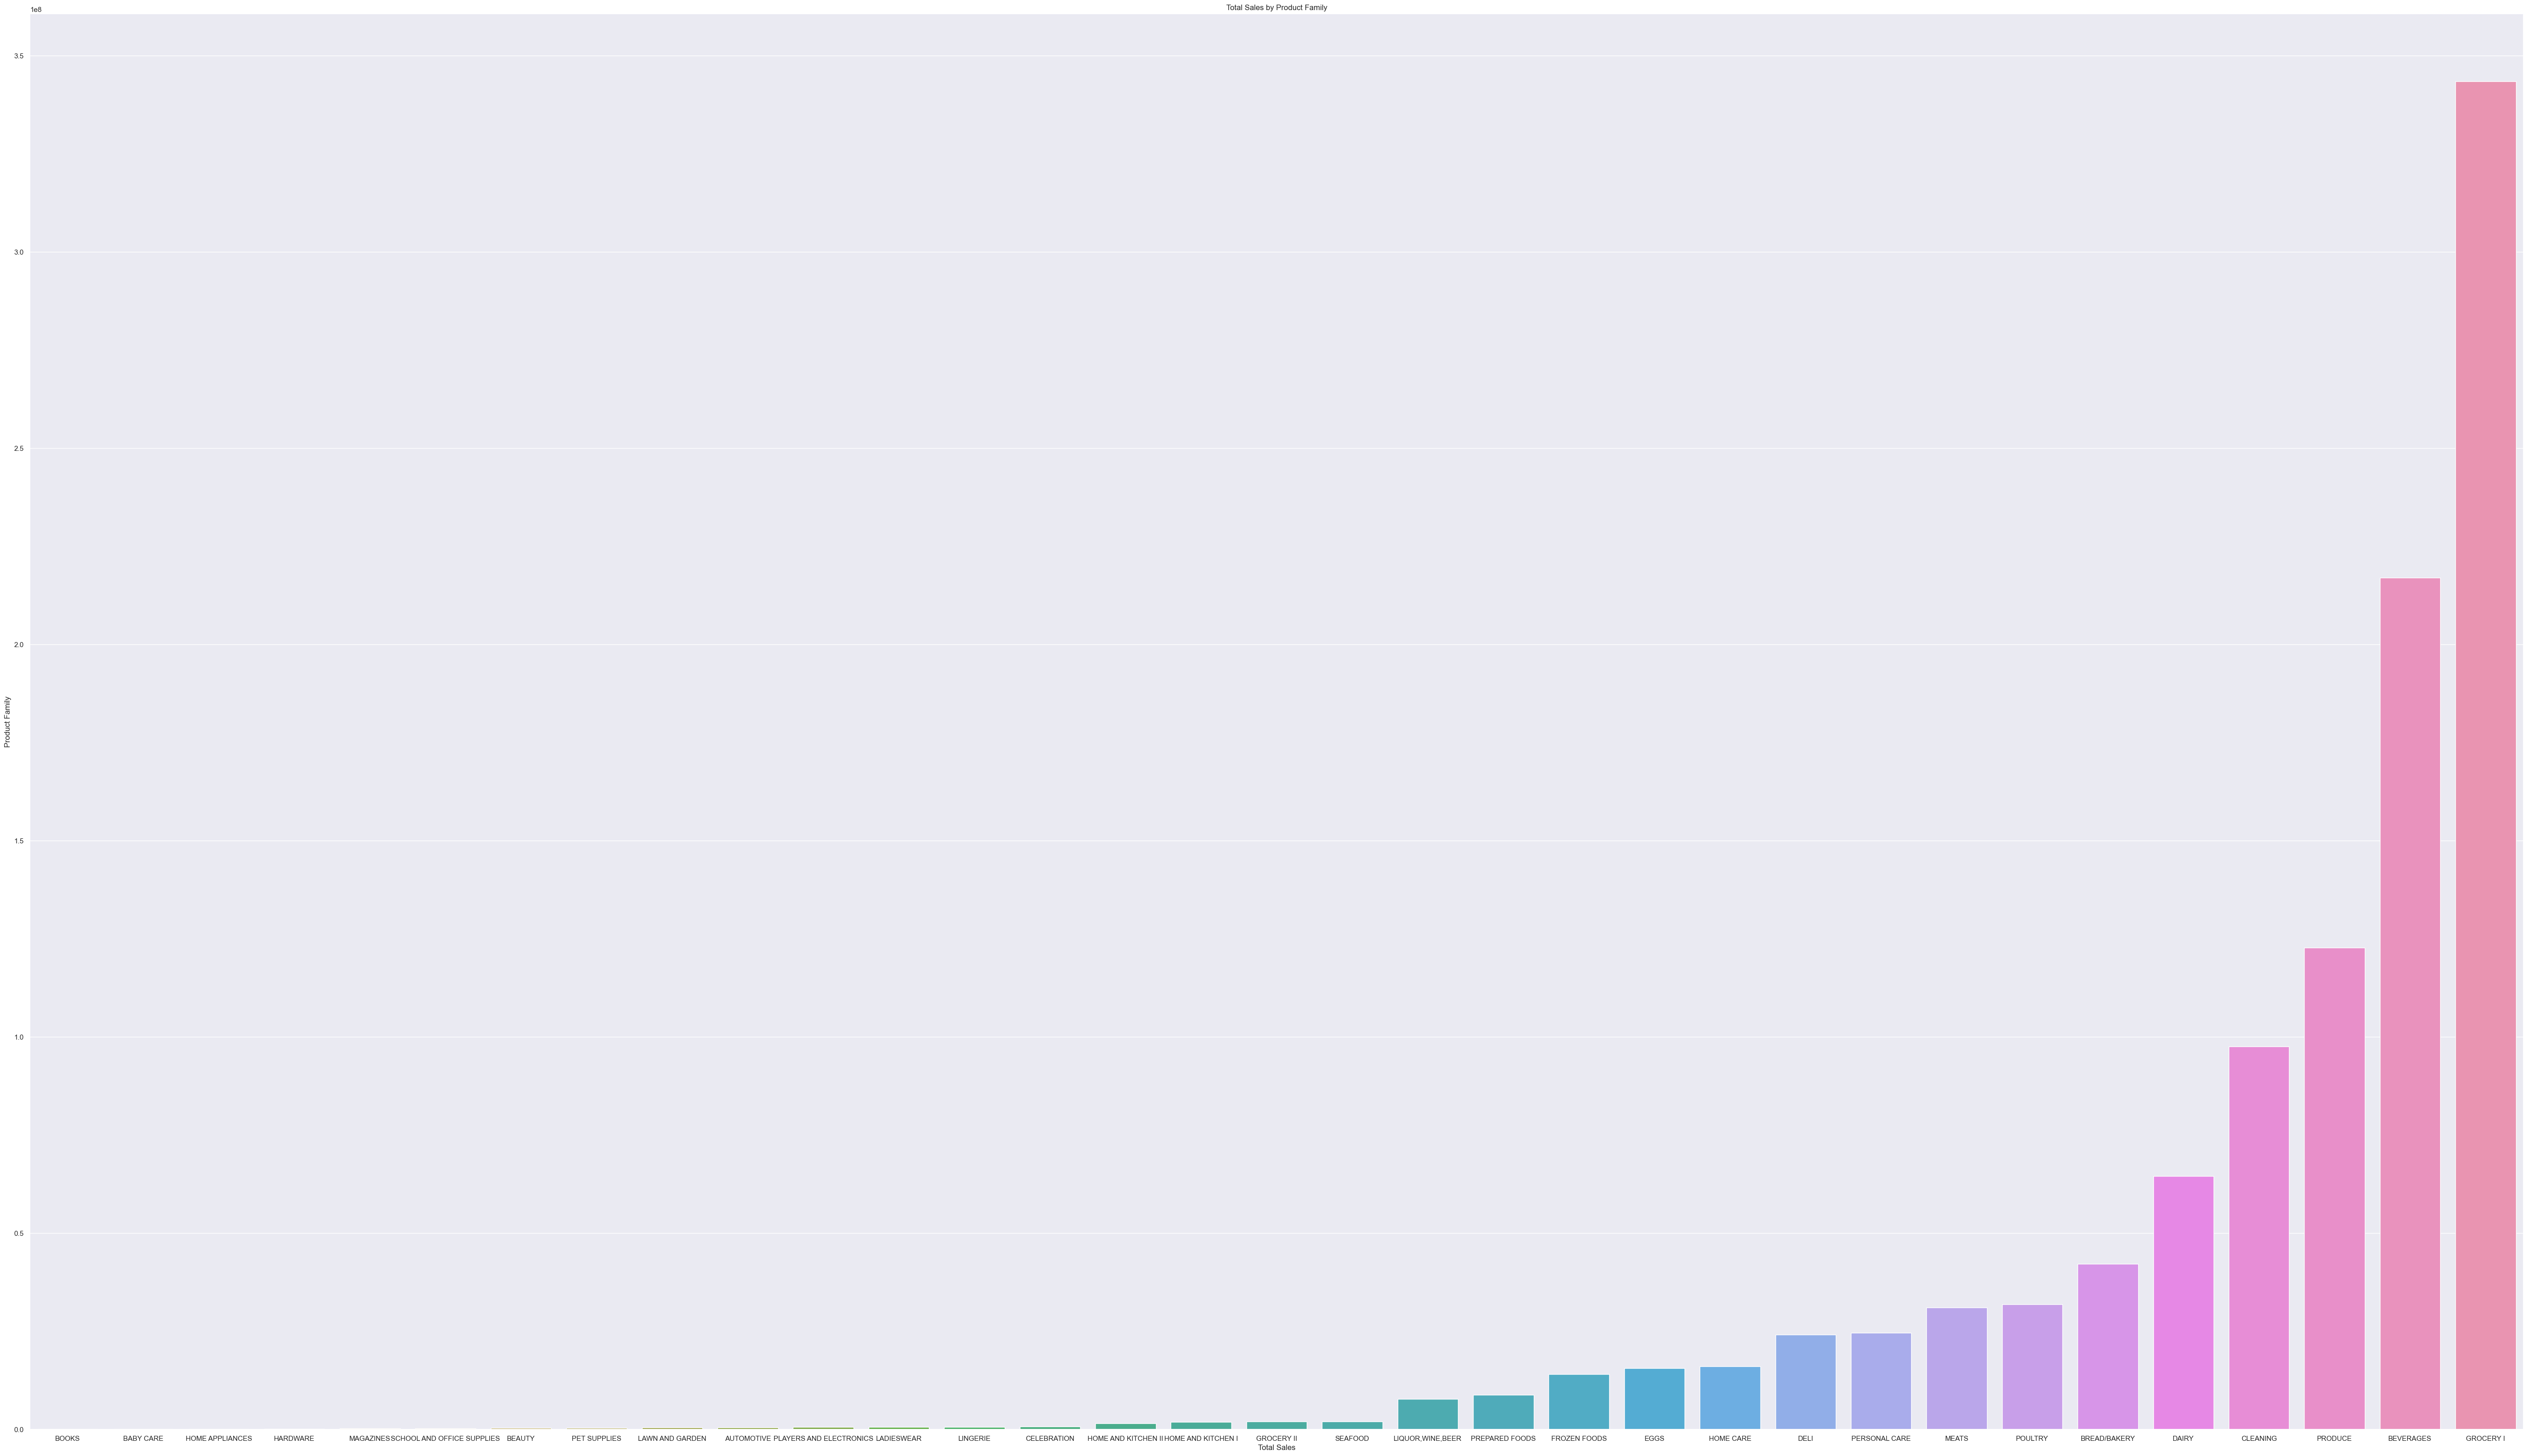

In [9]:
# sales by product
family_sales = train.groupby('family')['sales'].sum().sort_values()
plt.figure(figsize=(70,40))

sns.barplot(x=family_sales.index, y=family_sales.values)
plt.title("Total Sales by Product Family")
plt.xlabel("Total Sales")
plt.ylabel("Product Family")
plt.show()

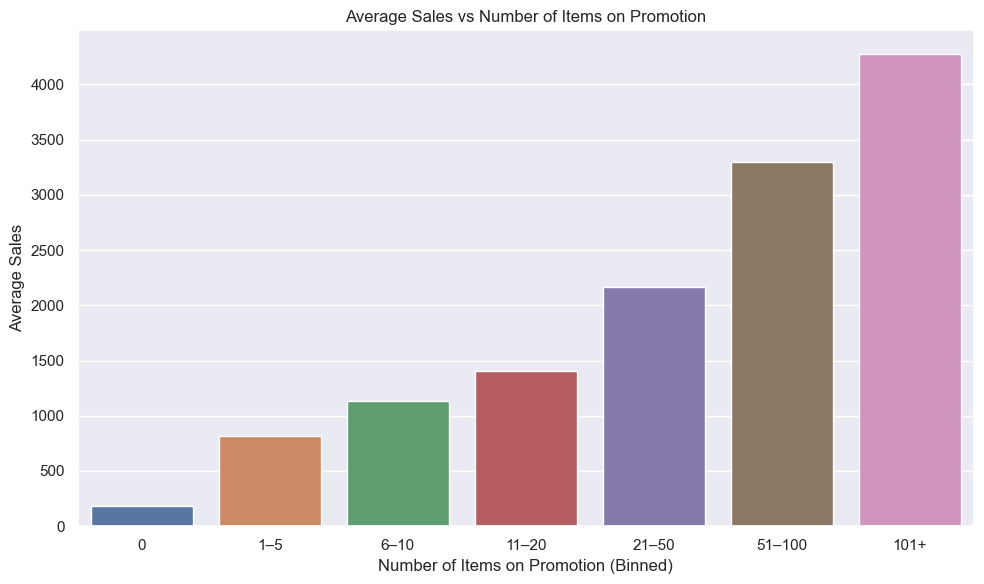

In [10]:
# promotional effect

# Create bins for promotional count
bins = [-1, 0, 1, 5, 10, 20, 50, 100, 1000]
labels = ['0', '1–5', '6–10', '11–20', '21–50', '51–100', '101+']
train['promo_bin'] = pd.cut(train['onpromotion'], bins=bins, labels=labels)

# Group by promo_bin and calculate average sales
promo_effect = train.groupby('promo_bin')['sales'].mean()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=promo_effect.index, y=promo_effect.values)
plt.title("Average Sales vs Number of Items on Promotion")
plt.xlabel("Number of Items on Promotion (Binned)")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

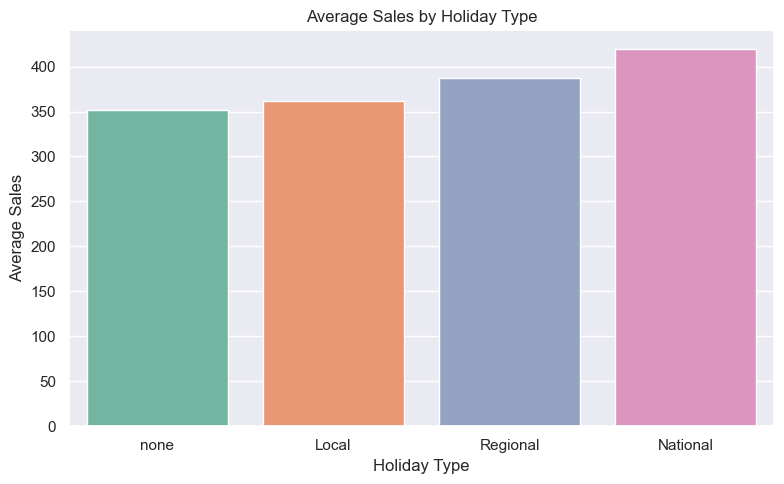

In [11]:
# effect of holiday
# Keep only real holidays (not transferred) and drop duplicates on date
holidays = holidays[~holidays['transferred']].copy()
holidays = holidays[['date', 'locale']].drop_duplicates()

train = train.merge(holidays, on='date', how='left')

# Fill NaN with 'none' for non-holiday days
train['holiday_type'] = train['locale'].fillna('none')

# Drop intermediate column if you want
train = train.drop(columns=['locale'])

# Group by holiday type and calculate average sales
holiday_type_sales = train.groupby('holiday_type')['sales'].mean().reset_index()

# Sort categories logically
holiday_order = ['none', 'Local', 'Regional', 'National']
holiday_type_sales['holiday_type'] = pd.Categorical(holiday_type_sales['holiday_type'], categories=holiday_order, ordered=True)
holiday_type_sales = holiday_type_sales.sort_values('holiday_type')

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(data=holiday_type_sales, x='holiday_type', y='sales', palette='Set2')
plt.title("Average Sales by Holiday Type")
plt.xlabel("Holiday Type")
plt.ylabel("Average Sales")
plt.tight_layout()
plt.show()

<Figure size 7000x4000 with 0 Axes>

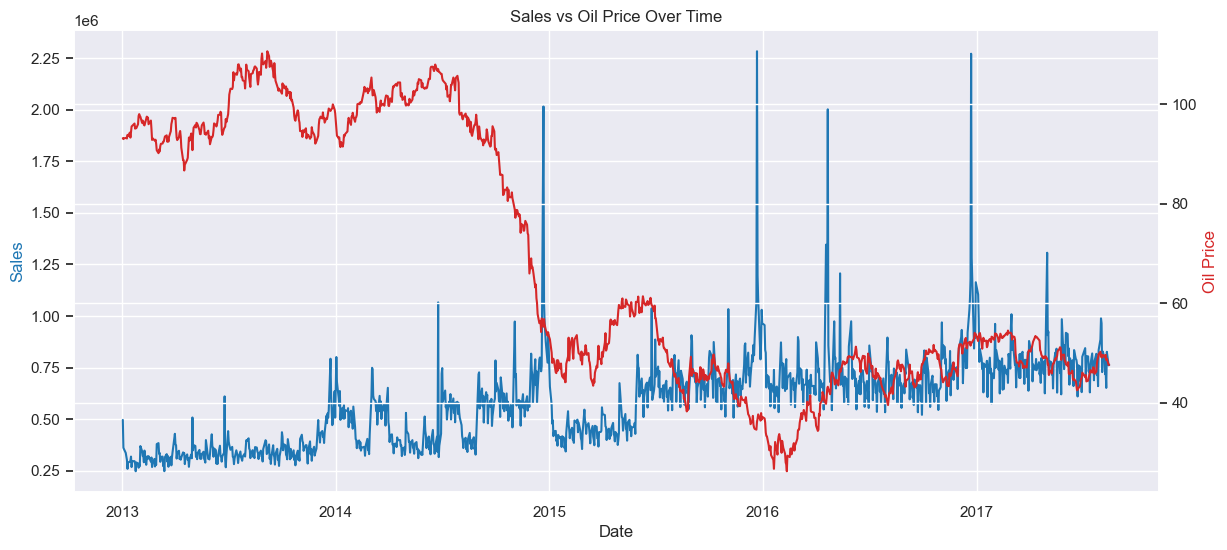

,sales,dcoilwtico
sales,1.000000,-0.649546
dcoilwtico,-0.649546,1.000000


In [12]:
# effect of oil 
# Merge oil data with daily sales
daily_sales = train.groupby('date')['sales'].sum().reset_index()
merged = pd.merge(daily_sales, oil, on='date', how='left').dropna()

plt.figure(figsize=(70,40))
fig, ax1 = plt.subplots()
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales', color='tab:blue')
ax1.plot(merged['date'], merged['sales'], color='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Oil Price', color='tab:red')
ax2.plot(merged['date'], merged['dcoilwtico'], color='tab:red')

plt.title("Sales vs Oil Price Over Time")
plt.show()

#find pearson's correlation coefficient
sales_oil = merged[['sales', 'dcoilwtico']]
sales_oil.corr()

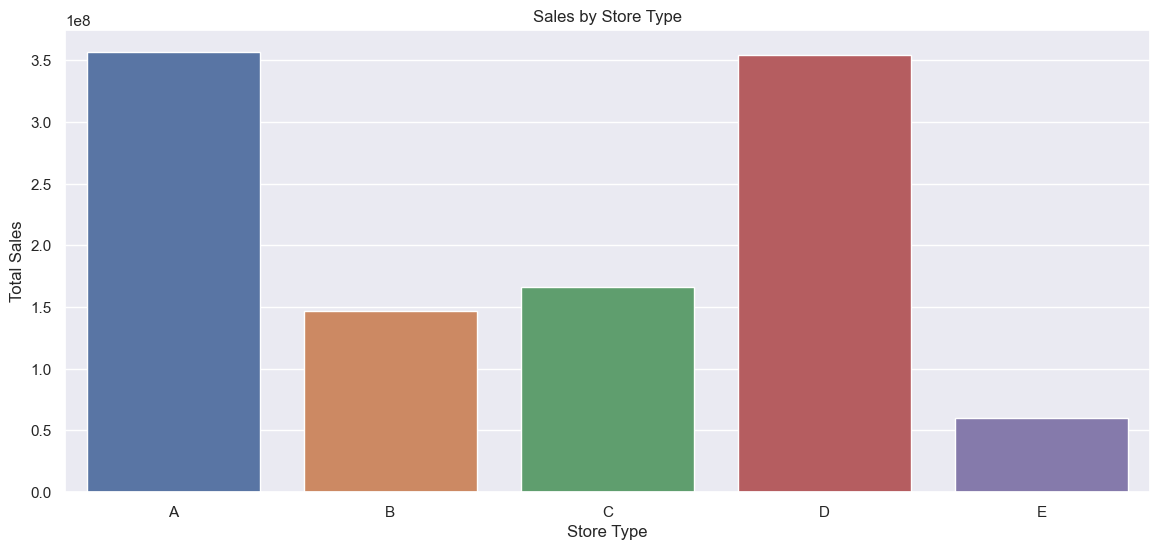

In [13]:
# Combine train with store metadata
store_info = train.merge(stores, on='store_nbr', how='left')

# Sales by store type
store_type_sales = store_info.groupby('store_type')['sales'].sum()
sns.barplot(x=store_type_sales.index, y=store_type_sales.values)
plt.title("Sales by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Total Sales")
plt.show()

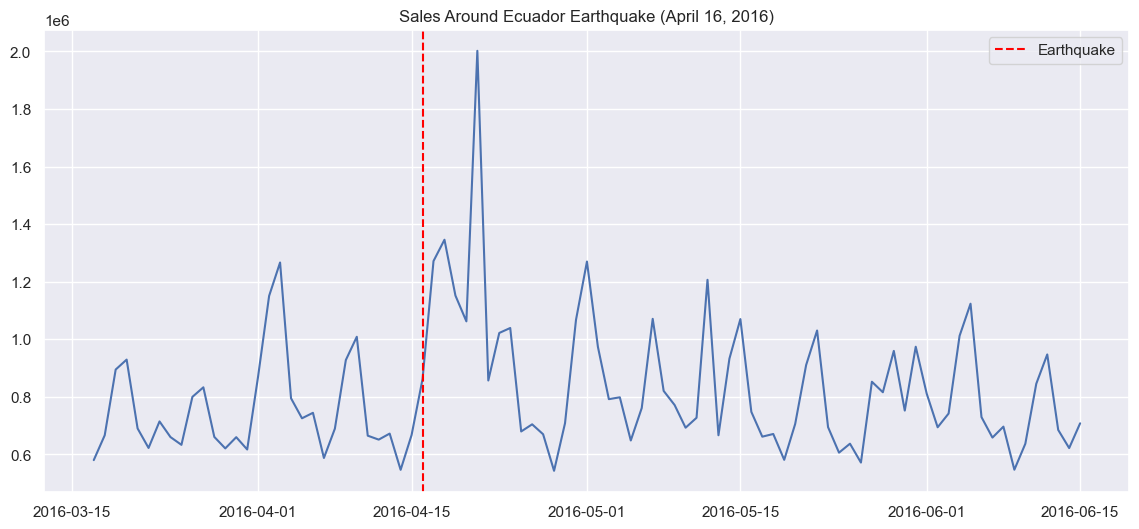

In [14]:
# earthquake impact

earthquake_date = pd.to_datetime('2016-04-16')
post_eq = train[(train['date'] >= earthquake_date - pd.Timedelta(days=30)) & 
                (train['date'] <= earthquake_date + pd.Timedelta(days=60))]

eq_trend = post_eq.groupby('date')['sales'].sum().reset_index()

plt.plot(eq_trend['date'], eq_trend['sales'])
plt.axvline(earthquake_date, color='red', linestyle='--', label='Earthquake')
plt.title("Sales Around Ecuador Earthquake (April 16, 2016)")
plt.legend()
plt.show()

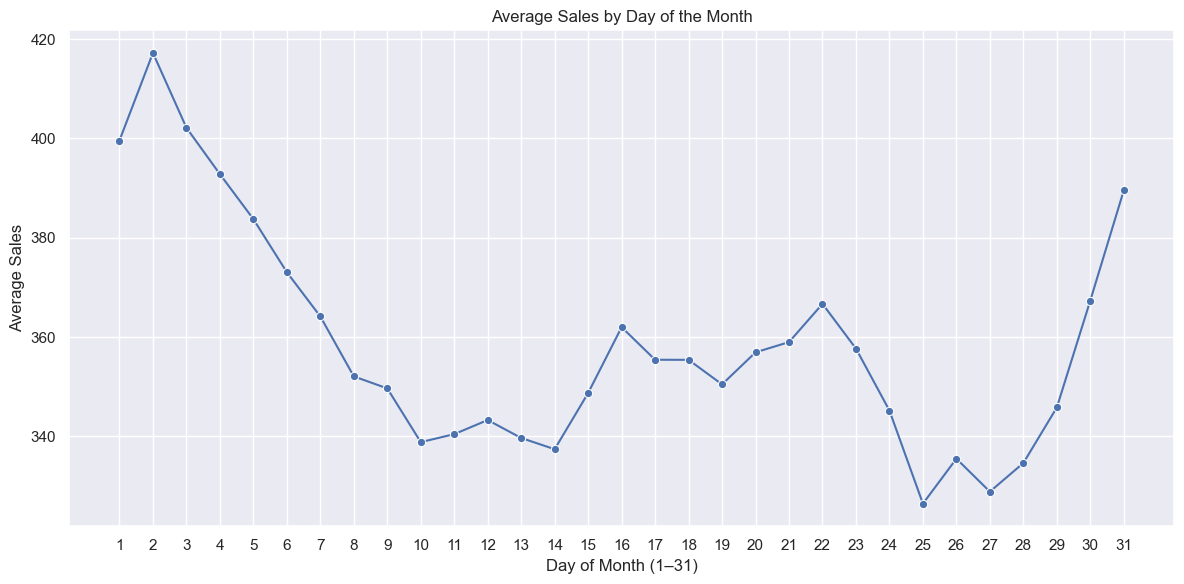

In [15]:
# seems like grocery store purchases follow strong monthly and weekly patterns
# mean sales by day of the month

# Extract day of month
train['day_of_month'] = train['date'].dt.day

# Group by day of month and calculate average sales
avg_sales_by_day = train.groupby('day_of_month')['sales'].mean().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.lineplot(data=avg_sales_by_day, x='day_of_month', y='sales', marker='o')
plt.title("Average Sales by Day of the Month")
plt.xlabel("Day of Month (1–31)")
plt.ylabel("Average Sales")
plt.xticks(range(1, 32))
plt.grid(True)
plt.tight_layout()
plt.show()

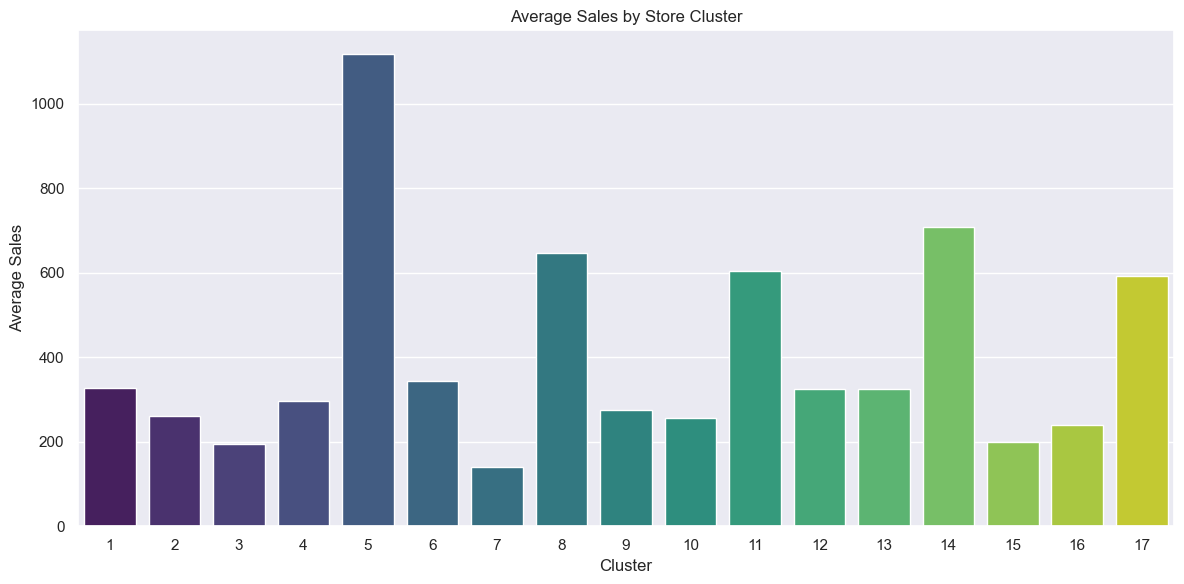

In [16]:
# Averages Sales by Store "Cluster"

# Merge store metadata into train set
train_merged = train.merge(stores, on='store_nbr', how='left')

# Group by cluster and compute mean sales
cluster_sales = train_merged.groupby('store_cluster')['sales'].mean().reset_index()
cluster_sales = cluster_sales.sort_values(by='sales', ascending=False)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_sales, x='store_cluster', y='sales', palette='viridis')
plt.title("Average Sales by Store Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Sales")
plt.xticks(rotation=0)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

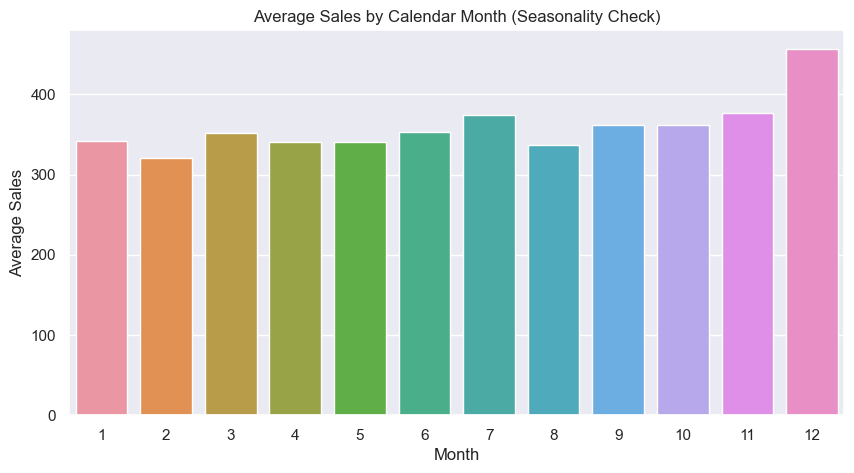

In [17]:
# Average Sales by Month Across All Years
train['month'] = train['date'].dt.month
monthly_avg = train.groupby('month')['sales'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.barplot(data=monthly_avg, x='month', y='sales')
plt.title("Average Sales by Calendar Month (Seasonality Check)")
plt.xlabel("Month")
plt.ylabel("Average Sales")
plt.show()

In [18]:
# findings: much stronger sales on the weekends, stronger sales very late/very early of the month
# store number, store types, store cluster are important signals
# product type, promotion crucially important
# holiday vs non-holiday is important

In [19]:
# (FEATURE ENGINEERING)

# weekday/weekend features
train['is_weekend'] = train['day_of_week'].isin([5, 6]).astype(int)

# time-of-month segments
def time_of_month(day):
    if day <= 5 or day >= 30:
        return 1
    else:
        return 0
        
train['early_late_flag'] = train['day_of_month'].apply(time_of_month)

# month of year (flag december)
train['is_december'] = (train['date'].dt.month == 12).astype(int)

# remove month & day-of-the week (contains a lot of noise)
train = train.drop(columns=['month'])
train = train.drop(columns=['day_of_week'])

# store type
train = train.merge(stores[['store_nbr', 'store_type']], on='store_nbr', how='left')

# store cluster
train = train.merge(stores[['store_nbr', 'store_cluster']], on='store_nbr', how='left')

In [20]:
# LABEL ENCODING
from sklearn.preprocessing import LabelEncoder

columns_to_encode = ['promo_bin', 'family', 'store_nbr', 'store_type', 'holiday_type']
encoders = {}

for col in columns_to_encode:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    encoders[col] = le

In [ ]:
# features I still need to add
# oil price, oil lag features, oil rolling promotion windows
# store family interaction

In [24]:
# lag features
train = train.sort_values(by=['store_nbr', 'family', 'date'])

# Create lag features
train['sales_lag_1'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1)
train['sales_lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['sales_lag_14'] = train.groupby(['store_nbr', 'family'])['sales'].shift(14)

train = train.dropna(subset=['sales_lag_1', 'sales_lag_7', 'sales_lag_14'])

In [25]:
# Rolling 7-day mean (shifted to avoid leakage)
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=7).mean()

# Rolling 7-day std dev
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=7).std()

train = train.dropna(subset=['rolling_mean_7', 'rolling_std_7'])

In [27]:
# Rolling 7-day promo count
train['promo_rolling_7'] = (
    train.groupby(['store_nbr', 'family'])['onpromotion']
    .shift(1)  # Shift to prevent leakage
    .rolling(window=7)
    .sum()
)

# Rolling 14-day promo count
train['promo_rolling_14'] = (
    train.groupby(['store_nbr', 'family'])['onpromotion']
    .shift(1)
    .rolling(window=14)
    .sum()
)

train = train.dropna(subset=['promo_rolling_7', 'promo_rolling_14'])

In [28]:
print(train.tail(20))
print(train.info())

              id       date  store_nbr  family  sales  onpromotion  \
2993627  2966897 2017-07-27         53      32    2.0            0   
2995409  2968679 2017-07-28         53      32    4.0            0   
2997191  2970461 2017-07-29         53      32    4.0            2   
2998973  2972243 2017-07-30         53      32    4.0            0   
3000755  2974025 2017-07-31         53      32    4.0            0   
3002537  2975807 2017-08-01         53      32    3.0            0   
3004319  2977589 2017-08-02         53      32    3.0            0   
3006101  2979371 2017-08-03         53      32    5.0            0   
3007883  2981153 2017-08-04         53      32    0.0            0   
3009665  2982935 2017-08-05         53      32    3.0            1   
3011447  2984717 2017-08-06         53      32    0.0            0   
3013229  2986499 2017-08-07         53      32    0.0            0   
3015011  2988281 2017-08-08         53      32   12.0            0   
3016793  2990063 201

In [ ]:
# new features to be added to train set
train['promo_bin']
train['is_holiday'] 
train['day_of_month']
train['is_weekend']
train['early_late_flag']
train['is_december']
train['store_type']
train['store_cluster']
train['holiday_type']
train['sales_lag_1']
train['sales_lag_7']
train['sales_lag_14']
train['rolling_mean_7']
train['rolling_std_7']
train['promo_rolling_7']
train['promo_rolling_14']

# remember to drop
train['id']
train['date']